In [0]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [0]:
path_ = ""
data=pd.read_csv( path_ + 'movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [0]:
edges = [tuple(x) for x in data.values.tolist()]

In [0]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [0]:
#A = list(nx.connected_component_subgraphs(B))[0]
A = [B.subgraph(c) for c in nx.connected_components(B) ][0]

In [0]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


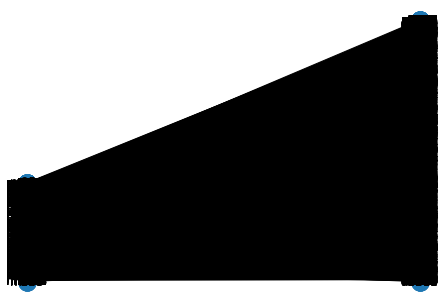

In [0]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [0]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [0]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [0]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [0]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [0]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

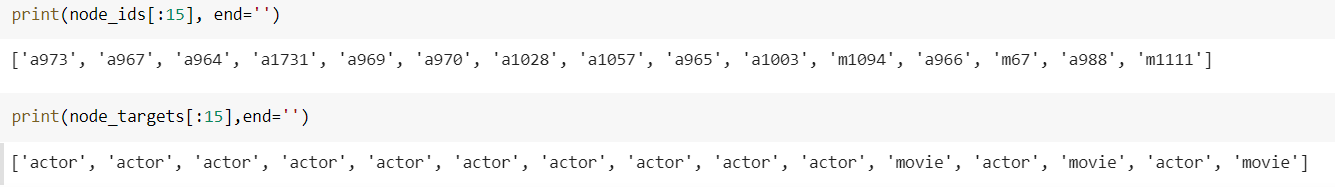

In [0]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for idx , node in enumerate(node_ids):
      if 'a' in node:
        actor_nodes.append( node )
        actor_embeddings.append( node_embeddings[ idx ] )
      elif 'm' in node:
        movie_nodes.append( node )
        movie_embeddings.append( node_embeddings[ idx ] )
    
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [0]:
actor_nodes, movie_nodes, actor_embeddings, movie_embeddings = data_split(node_ids,node_targets,node_embeddings)

In [0]:
def cost1(graph, number_of_clusters):
    '''In this function, we will calculate cost1'''
    G = graph
    total_nodes = G.number_of_nodes()

    components = [G.subgraph(c) for c in nx.connected_components(G) ]

    components_node_no_list = []
    
    for idx , component in enumerate( components ):
      components_node_no_list.append( component.number_of_nodes() )

    nodes_in_largest_component = np.max( np.array( components_node_no_list ) )
    
    cost1= (nodes_in_largest_component / total_nodes) * ( 1 / number_of_clusters )
    
    return cost1

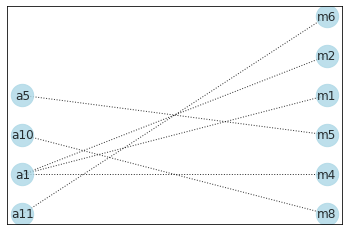

In [0]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [0]:
def cost2(graph, number_of_clusters):
    '''In this function, we will calculate cost1'''
    G = graph
    movies_in_graph = []
    for i in G.nodes():
        if 'm' in i:
            movies_in_graph.append(i)

    movies_unique_nodes = len( set( movies_in_graph ) )
    
    degree_of_actors_node = G.number_of_edges()

    cost2= ( degree_of_actors_node / movies_unique_nodes ) * ( 1 / number_of_clusters )
    
    return cost2

In [0]:
def edges_split( nodes_ids ):
  actor_edge_indices = []
  movie_edge_indices = []
  for idx , node in enumerate(nodes_ids):
      if 'a' in node:
        actor_edge_indices.append( idx )
      elif 'm' in node:
        movie_edge_indices.append( idx )
  return actor_edge_indices , movie_edge_indices


def get_custer_wise_edges(kmeans_labels_ , edges_list  , labeled_edge_idx  , no_of_cluster ):
  
  arr_of_cluster_edges = [ [] for i in range( no_of_cluster )]
  
  for idx , cluster_no in enumerate(kmeans_labels_):
    arr_of_cluster_edges[ cluster_no ].append( edges_list[ labeled_edge_idx[idx] ] )
  
  return arr_of_cluster_edges

In [0]:
def create_graph( cluster_edges ):

  movie_node = []
  actor_node = []

  for idx , nodes in enumerate( cluster_edges ):
      
      for node in nodes:
        if 'a' in node:
          actor_node.append( node )
        elif 'm' in node:
          movie_node.append( node )
  
  G = nx.Graph()
  G.add_nodes_from( np.array(list(set(movie_node))), bipartite=0, label='movie')
  G.add_nodes_from( np.array(list(set(actor_node))), bipartite=1, label='actor')
  G.add_edges_from( cluster_edges  , label='acted')

  return G

In [0]:
def compute_cost1_cost2( arr_of_cluster_edges , number_of_clusters ):

  cost_1 = []
  cost_2 = []
  no_of_clusters = len( arr_of_cluster_edges )

  for idx , cluster_edge in enumerate( arr_of_cluster_edges ):
    G = create_graph( cluster_edge )
    
    c1 = cost1( G , number_of_clusters )
    c2 = cost2( G , number_of_clusters )
    
    cost_1.append( c1 )
    cost_2.append( c2 )

  sum_of_cost1 = np.sum( np.array( cost_1 ))
  sum_of_cost2 = np.sum( np.array( cost_2 )) 

  total_cost = sum_of_cost1 * sum_of_cost2
  return total_cost

In [0]:
indices_of_actor_edge , indices_of_movie_edge = edges_split( node_ids )

edges_list = list(edges)

In [0]:
#compute cost for actors
print("cost for actors : \n")

for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  print("number of cluster : " , number_of_clusters)
  kmeans = KMeans(n_clusters= number_of_clusters )
  kmeans.fit( actor_embeddings )

  cluster_wise_edges_of_groups = get_custer_wise_edges( kmeans.labels_ , edges_list  , indices_of_actor_edge  , number_of_clusters )
  
  total_cost = compute_cost1_cost2( cluster_wise_edges_of_groups , number_of_clusters)
  print("total cost         : " , total_cost )
  print("="*50)

cost for actors : 

number of cluster :  3
total cost         :  1.5553901926217215
number of cluster :  5
total cost         :  0.8976035990882169
number of cluster :  10
total cost         :  0.48301835827919765
number of cluster :  30
total cost         :  0.3186565643333196
number of cluster :  50
total cost         :  0.3854200338691842
number of cluster :  100
total cost         :  0.5065135037700043
number of cluster :  200
total cost         :  0.5383707574415855
number of cluster :  500
total cost         :  0.6266979618298574


In [0]:
# 2-D matrix using TSNE
transform_a = TSNE

trans_a = transform_a(n_components=2)
actor_embeddings_2d = trans_a.fit_transform( np.array( actor_embeddings ) )

In [0]:
# shape of actor_embeddings , actor_embeddings_2d
np.array(actor_embeddings).shape , actor_embeddings_2d.shape

((3411, 128), (3411, 2))

In [0]:
#k-means of actor_embeddings for max cost of number of clusters
kmeans_a = KMeans(n_clusters=3)
kmeans_a.fit( actor_embeddings_2d )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

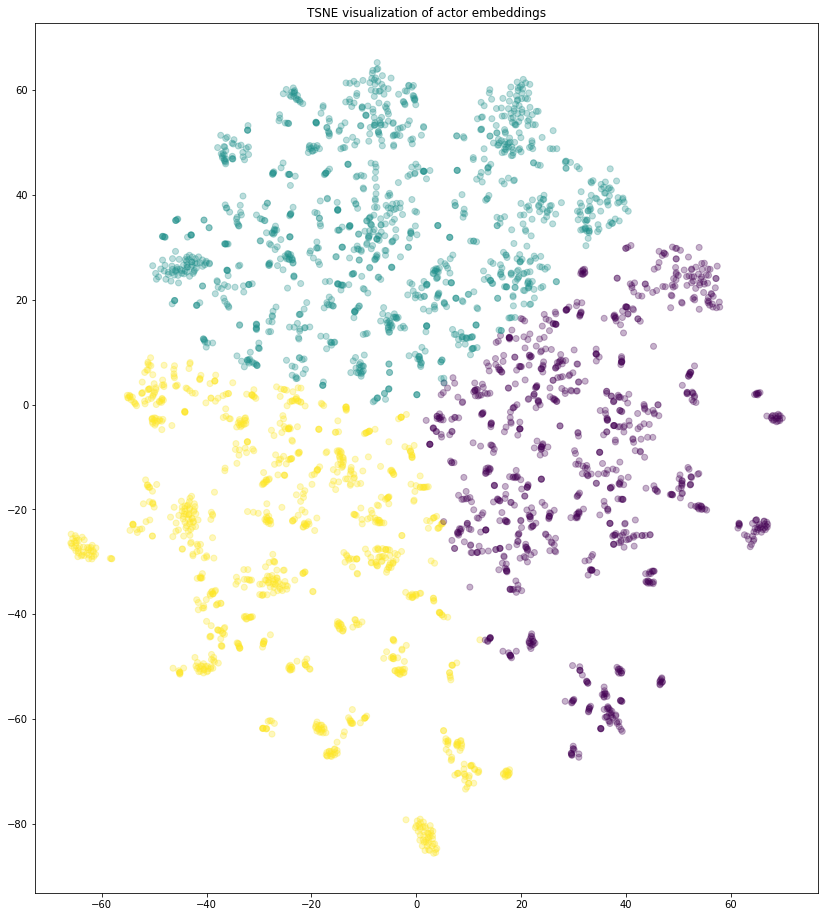

In [0]:
#plot similar actors clusters

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter( actor_embeddings_2d[:,0], 
             actor_embeddings_2d[:,1], 
            c= kmeans_a.labels_ , alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform_a.__name__))

plt.show()

In [0]:

def get_cost2_of_movies( G , number_of_clusters ):
  actors_in_graph = []
  for i in G.nodes():
      if 'a' in i:
          actors_in_graph.append(i)

  actors_unique_nodes = len( set( actors_in_graph ) )
  
  degree_of_movies_node = G.number_of_edges()

  cost2 = ( degree_of_movies_node / actors_unique_nodes ) * ( 1 / number_of_clusters )
  return  cost2

def compute_cost1_cost2_of_movies( arr_of_cluster_edges , number_of_clusters ):

  cost_1 = []
  cost_2 = []

  for idx , cluster_edge in enumerate( arr_of_cluster_edges ):
    G = create_graph( cluster_edge )
    
    c1 = cost1( G , number_of_clusters )
    c2 = get_cost2_of_movies( G , number_of_clusters )
    
    cost_1.append( c1 )
    cost_2.append( c2 )

  sum_of_cost1 = np.sum( np.array( cost_1 ))
  sum_of_cost2 = np.sum( np.array( cost_2 ))

  total_cost = sum_of_cost1 * sum_of_cost2
  return total_cost

In [0]:
#compute cost for movies
print("cost for movies : \n")

for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
  print("number of cluster : " , number_of_clusters)
  kmeans_m = KMeans(n_clusters= number_of_clusters )
  kmeans_m.fit( movie_embeddings )

  cluster_wise_edges_of_groups = get_custer_wise_edges( kmeans_m.labels_ , edges_list  , indices_of_movie_edge  , number_of_clusters )
  
  total_cost_m = compute_cost1_cost2_of_movies( cluster_wise_edges_of_groups , number_of_clusters )
  print("total cost         : " , total_cost_m )
  print("="*50)

cost for movies : 

number of cluster :  3
total cost         :  0.18967661539921515
number of cluster :  5
total cost         :  0.14357588671937843
number of cluster :  10
total cost         :  0.1301494853348772
number of cluster :  30
total cost         :  0.19616299083845243
number of cluster :  50
total cost         :  0.22936362397213106
number of cluster :  100
total cost         :  0.4593861604843526
number of cluster :  200
total cost         :  0.6459868647755559
number of cluster :  500
total cost         :  0.836499966049729


In [0]:
#2-D movie_embeddings using TSNE
transform_m = TSNE #PCA

trans_m = transform_m(n_components=2)
movie_embeddings_2d = trans_m.fit_transform( np.array( movie_embeddings ) )

In [0]:
# shape of movie_embeddings_2d
np.array( movie_embeddings ).shape , movie_embeddings_2d.shape

((1292, 128), (1292, 2))

In [0]:
# k-means of movie_embeddings
kmeans_mov = KMeans(n_clusters= 500 )
kmeans_mov.fit( movie_embeddings_2d )

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=500, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

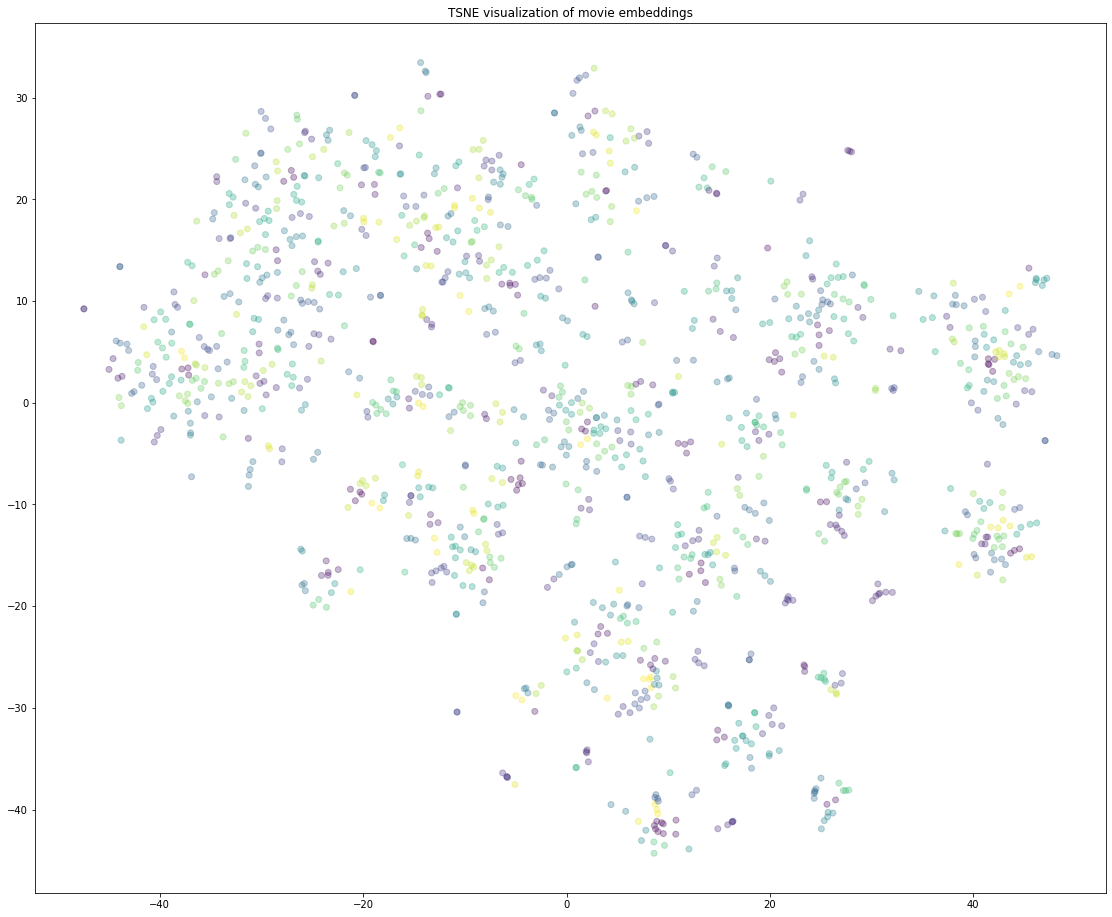

In [0]:
# plot similar movies clusters
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter( movie_embeddings_2d[:,0], 
             movie_embeddings_2d[:,1], 
            c= kmeans_mov.labels_ , alpha=0.3)

plt.title('{} visualization of movie embeddings'.format(transform_m.__name__))

plt.show()